# SimpleRNN

SimpleRNN으로 모형을 구성하여 텍스트 데이터를 분류하는 텍스트 분류기를 생성한다.  

먼저 텍스트 데이터를 변환하는 방법을 알아보고 tf.keras의 SimpleRNN layer를 사용하여 모형을 구현한다.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


# RNN으로 감성분석

imdb 데이터를 다운로드하여 긍정(1)/부정(0) 평가를 분류한다.
* SimpleRNN, TBPTT
* Embedding

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN


### 데이터 준비

* IMDB Movie Review 데이터셋을 이용한 감정 분석(Sentiment Analysis) 문제를 처리해보자.

* imdb 데이터셋에는 IMDB 영화 리뷰 내용을 단어로 tokenize하여 인코딩한 데이터 이다. 리뷰에 포함된 8만개 이상의 단어를 고유한 정수로 인코딩하였다.

* 긍정 = 1, 부정 = 2 로 label되어 있다. 

* 훈련 데이터 2만 5천건, 테스트 데이터 2만5천 건이 포함되어 있다.

* 훈련 데이터를 나누어 5000개를 validation set로 사용한다.


In [3]:
import numpy as np
from tensorflow.keras.datasets import imdb

### `imdb.load_data`

* skip_top : 가장 많이 사용된 단어 중 skip할 단어의 갯수를 지정한다. a, the, is 와 같이 많이 등장하지만 분석에 유용하지 않은 단어를 건터 뛴다. 

* num_words : 훈련에 사용할 단어의 갯수를 지정한다. 이 실습의 경우에 단어의 수를 너무 크게 하면 원-핫 인코딩에 사용되는 메모리가 너무 커지므로 100개로 한정한다.

In [4]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

17464789/17464789 [==============================] - 1s 0us/step


In [5]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [6]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


단어 들 중에 숫자 2는 단어 사전에 없는 데이터로 가장 많이 등장하는 단어 20개를 제외하고 단어 100개만을 선택했으므로 사전에 없는 단어가 많다. 이를 훈련 데이터에서 제외한다.

추가로 0은 패딩, 1은 글의 시작을 나타낸다. 이 또한 제외하고 훈련 데이터 를 구성한다.

In [7]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


쉽게 이해하도록 숫자를 단어로 바꾸어 보자. get_word_index 함수로 숫자를 단어로 바꿀수 있다. 

In [8]:
word_to_index = imdb.get_word_index()
word_to_index['movie']

1641221/1641221 [==============================] - 0s 0us/step


17

In [9]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w-3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

훈련 데이터의 길이를 확인해 보면 각 리뷰마다 글의 길이가 다르다. 이 처럼 텍스트의 길이가 제각각이면 훈련된 될 수 없다. 따라서 샘플 데이터의 길이를 동일하게  맞추어야 한다.

In [10]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


긍정 = 1

부정 = 0

In [11]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [12]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=123)

print(x_train.shape, x_val.shape)


(20000,) (5000,)


### 샘플의 길이 맞추기

샘플 데이터의 길이를 동일하게 맞추어야 한다.

* 일정 길이가 넘으면 앞에서 부터 단어를 잘라버린다.
* 일정 길이에서 모자라면 앞부분에 0을 채운다(패딩)


In [13]:
from tensorflow.keras.preprocessing import sequence

max_len = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=max_len)
x_val_seq = sequence.pad_sequences(x_val, maxlen=max_len)

print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [14]:
print(x_train[0])
print(x_train_seq[0])

[44, 85, 74, 21, 95, 33, 85, 67, 48, 27, 86, 42, 20, 21, 57, 29, 23, 29, 23, 31, 65, 99, 43, 88, 21, 47, 88, 50, 71, 49, 21, 20]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 44 85 74 21
 95 33 85 67 48 27 86 42 20 21 57 29 23 29 23 31 65 99 43 88 21 47 88 50
 71 49 21 20]


### One Hot encoding

단어를 수치로 바꾸는 가장 간단한 방법이 원-핫 인코딩 방식이다. 

원-핫 인코딩 벡터의 차원은 전체 vocalburary(전체 어휘) 개수이다. 

![IMG](../assets/onehot.png)


In [15]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

print(x_train_onehot.shape)

(20000, 100, 100)


단어를 100개로 제한 했는데도 생성된 원-핫벡터의 크기가 800메가에 가깝다. 단어의 갯수가 늘어나면 그만큼 더 많은 메모리가 필요하다.

In [16]:
print(x_train_onehot.nbytes)

800000000


### SimpleRNN 클래스로 모형 생성하기

* RNN의 cell의 갯수를 32로 한다.
* time_step의 길이(문장의 길이)가 100이고 원-핫 인코딩의 크기가 100이므로 입력크기는 (100,100)이다.

* 긍정/부정 이진분류이므로 dense층의 유닛은 1이다. 출력층의 활성화 함수는 sigmoid를 사용한다.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [18]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100,100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


### 모델 compile & 모델 훈련하기

In [19]:
model.compile(optimizer='sgd',loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=10, batch_size=32, validation_data=(x_val_onehot, y_val))

Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.7036 - accuracy: 0.5167 - val_loss: 0.6941 - val_accuracy: 0.5298
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6786 - accuracy: 0.5719 - val_loss: 0.6622 - val_accuracy: 0.6028
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.6569 - accuracy: 0.6137 - val_loss: 0.6407 - val_accuracy: 0.6368
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6348 - accuracy: 0.6425 - val_loss: 0.6571 - val_accuracy: 0.6144
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.6316 - accuracy: 0.6526 - val_loss: 0.6051 - val_accuracy: 0.6736
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 0.6119 - accuracy: 0.6676 - val_loss: 0.6225 - val_accuracy: 0.6526
Epoch 7/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6188 - accuracy: 0.6640 - val_loss: 0.6043 - val_accuracy: 0.6

### 훈련결과 시각화

In [20]:
import matplotlib.pyplot as plt
# %matplotlib inline

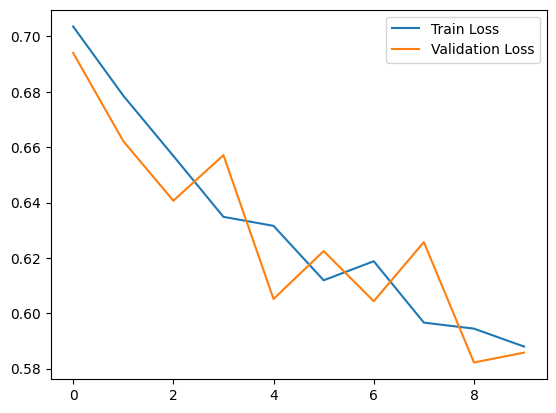

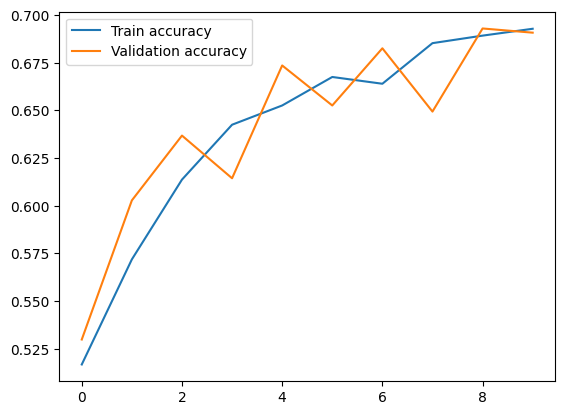

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [22]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)

print(accuracy)

0.6908000111579895
